<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/08-Visualization/Visualization_Examples-NCDC_Normals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from io import StringIO
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
# Increase the font size to 150%
sns.set(font_scale = 1.5)
# Set the style to have white color and a grid
sns.set_style("whitegrid")

# NOAA'S 1981-2010 Climate Normals

[Description of the dataset](https://www1.ncdc.noaa.gov/pub/data/normals/1981-2010/readme.txt)

## Loading the dataset

### Load the weather stations

In [3]:
# Read the file directly from the URL. If it is a "Fixed Width File", so we use the .read_fwf command
stations = pd.read_fwf('https://www1.ncdc.noaa.gov/pub/data/normals/1981-2010/station-inventories/allstations.txt', header=None)

# From the README, we know the meaning of the different columns
stations.columns = ['station_id', 'lat', 'lon', 'elevation', 'state', 'name', 'is_GSN_station', 'is_HCN_station', 'WMO_number' ]

# We drop unecessary columns
stations = stations.drop(['is_GSN_station', 'is_HCN_station', 'WMO_number'], axis='columns')

# We only keep stations located in the US
condition = stations["station_id"].str.startswith("US")
stations = stations[ condition ]

stations

,station_id,lat,lon,elevation,state,name
116,USC00010008,31.5703,-85.2483,139.0,AL,ABBEVILLE
117,USC00010063,34.2553,-87.1814,249.3,AL,ADDISON
118,USC00010140,32.2322,-87.4103,53.3,AL,ALBERTA
119,USC00010160,32.9453,-85.9481,195.1,AL,ALEXANDER CITY
120,USC00010178,33.1272,-88.1550,59.4,AL,ALICEVILLE
...,...,...,...,...,...,...
9865,USW00094992,47.7472,-90.3444,185.9,MN,GRAND MARAIS
9866,USW00094993,45.6689,-96.9914,353.9,SD,SISSETON MUNI AP
9867,USW00094994,43.1561,-90.6775,204.8,WI,BOSCOBEL AP
9868,USW00094995,40.8483,-96.5650,362.4,NE,LINCOLN 8 ENE


### Load the temperature measurements

This data file requires a bit of data wrangling to get it into the format that we want.

In [4]:
# read the fixed width file
data_url = "https://www1.ncdc.noaa.gov/pub/data/normals/1981-2010/products/temperature/dly-tavg-normal.txt"

# We set the infer_nrows to a large value, because otherwise
# some columns that have length greater than 4 get truncated
# (e.g., all the temperatures > 100 in Dealth Valley get truncated
# to values close to 0, because the leading 1 is missing)
df = pd.read_fwf(data_url, header=None, infer_nrows=100000, dtype="object")

In [5]:
# column names for the fixed-width file
# The format is station, month, and then one column per day
columns = ["station_id", "month"]
days = [f"{i:02.0f}" for i in range(1, 32)]
df.columns = columns + days

In [6]:
# un-pivot the table
# We keep ["station_id", "month"] as column names and we convert
# the remaining columns that correspond to days into values, under
# the column "day"
df = pd.melt(df, id_vars=columns, value_vars=days, var_name="day")

In [7]:
# extract the number and the flag from the temperature using a regex
regex = r"(-*\d+)(\w*)"
df = pd.concat([df, df["value"].str.extract(regex)], axis="columns")
df = df.drop("value", axis="columns")
df.columns = ["station_id", "month", "day", "temperature", "flag"]

In [8]:
# Remove dummy values from temperature and
# convert to F by dividing by 10
df["temperature"] = pd.to_numeric(df["temperature"])
df = df[df["temperature"] != -8888]
df["temperature"] = df["temperature"] / 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
# Keep only entries that are "Complete", "Standard"
df = df[df["flag"].isin(['C','S','R'])]

In [10]:
# Convert month-day pairs to actual dates
df["date"] = "2000-" + df["month"].astype(str) + "-" + df["day"].astype(str)
df["date"] = pd.to_datetime(df["date"])

In [11]:
# join with the details of each station
df = pd.merge(df, stations)

## Pick data for a few selected locations

In [12]:
# The list of stations that we want to plot
# and their friendly names (we will use the 
# friendly names to rename the time series later)
list_stations = {
    "USC00042319": "Death Valley",  # Death Valley, CA 92328 hottest point in the US
    "USW00094728": "New York",  # New York, NY 10012
    "USW00093107": "San Diego",  # San Diego, CA 92145
    "USW00012918": "Houston",  # Houston, TX 77061
    "USW00027502": "Barrow", # Barrow, AK 99723, coldest point in the US
    
    #"USC00516128": "Honolulu", # Honolulu, HI 96813
}

In [13]:
"['" + "','".join(list_stations.keys()) + "']"

"['USC00042319','USW00094728','USW00093107','USW00012918','USW00027502']"

In [14]:
# Keep only the data for the selected stations
condition = df['station_id'].isin(list_stations.keys())
data = df[condition].sort_values(['station_id','date'])
data

,station_id,month,day,temperature,flag,date,lat,lon,elevation,state,name
129564,USC00042319,01,01,51.0,S,2000-01-01,36.4622,-116.8669,-59.1,CA,DEATH VALLEY
129576,USC00042319,01,02,51.2,S,2000-01-02,36.4622,-116.8669,-59.1,CA,DEATH VALLEY
129588,USC00042319,01,03,51.3,S,2000-01-03,36.4622,-116.8669,-59.1,CA,DEATH VALLEY
129600,USC00042319,01,04,51.4,S,2000-01-04,36.4622,-116.8669,-59.1,CA,DEATH VALLEY
129612,USC00042319,01,05,51.6,S,2000-01-05,36.4622,-116.8669,-59.1,CA,DEATH VALLEY
...,...,...,...,...,...,...,...,...,...,...,...
2285382,USW00094728,12,27,34.3,C,2000-12-27,40.7789,-73.9692,39.6,NY,NEW YORK CNTRL PK TWR
2285394,USW00094728,12,28,34.1,C,2000-12-28,40.7789,-73.9692,39.6,NY,NEW YORK CNTRL PK TWR
2285406,USW00094728,12,29,33.9,C,2000-12-29,40.7789,-73.9692,39.6,NY,NEW YORK CNTRL PK TWR
2285417,USW00094728,12,30,33.7,C,2000-12-30,40.7789,-73.9692,39.6,NY,NEW YORK CNTRL PK TWR


## Create a Line Plot

In [15]:
# Create a pivot table with the stations as columns
pivot = data.pivot_table(
    index="date", 
    columns="station_id", 
    values="temperature"
)

# Change the name of the columns to use the friendly names
pivot.rename(list_stations, axis="columns", inplace=True)

# Date is the index and Station IDs the columns
pivot

station_id,Death Valley,Houston,Barrow,San Diego,New York
date,,,,,
2000-01-01,51.0,53.9,-11.3,55.2,33.4
2000-01-02,51.2,53.8,-11.5,55.3,33.3
2000-01-03,51.3,53.8,-11.8,55.3,33.1
2000-01-04,51.4,53.8,-12.0,55.4,33.0
2000-01-05,51.6,53.8,-12.1,55.4,32.9
...,...,...,...,...,...
2000-12-27,50.6,54.1,-10.2,55.0,34.3
2000-12-28,50.7,54.1,-10.5,55.0,34.1
2000-12-29,50.8,54.0,-10.7,55.1,33.9


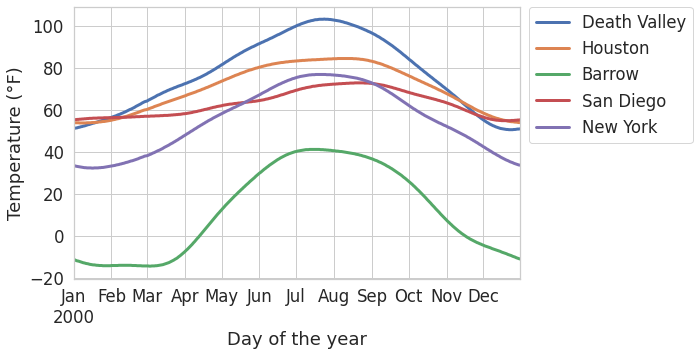

In [16]:
ax = pivot.plot(
    grid=True, 
    figsize=(8,5), 
    linewidth=3
)
ax.set_xlabel("Day of the year")
ax.set_ylabel("Temperature (°F)")

# Put the legend a bit outside the box
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
pass 

### Line plot, using redundant encoding for location (both line color, and line style)

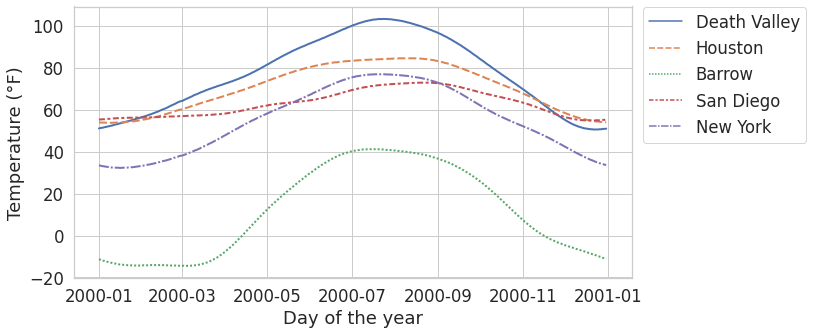

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(data=pivot, linewidth=2)
ax.set_xlabel("Day of the year")
ax.set_ylabel("Temperature (°F)")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
pass

### Line plot, using polar coordinates for the time of the year

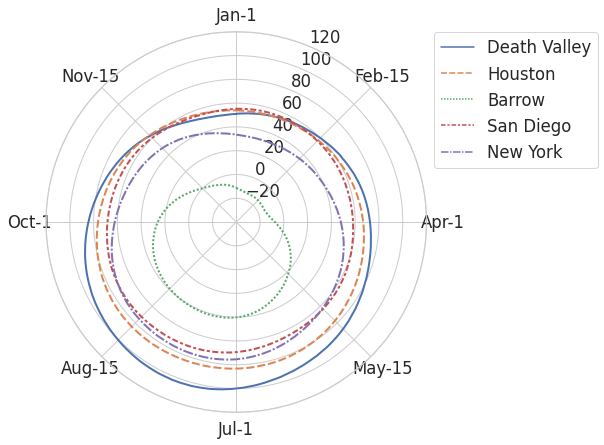

In [18]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,7))
times = pd.date_range("01/01/2000", "12/31/2000")
t = mdates.date2num(pivot.index.to_pydatetime())
tnorm = (t-t.min())/(t.max()-t.min())*2.*np.pi
ax.set_ylim(-40,120)
ax.set_xticklabels(['Jan-1', 'Feb-15', 'Apr-1', 'May-15', 'Jul-1', 'Aug-15', 'Oct-1', 'Nov-15'])
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
sns.lineplot(data=pivot.set_index(tnorm), linewidth=2)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
pass

## Create a Heatmap

In [19]:
# We create temperature data with monthly
heatmap = pivot.resample("1M").mean()
heatmap

station_id,Death Valley,Houston,Barrow,San Diego,New York
date,,,,,
2000-01-31,53.451613,54.041935,-13.412903,55.845161,32.606452
2000-02-29,59.944828,57.341379,-14.203448,56.517241,35.348276
2000-03-31,68.448387,63.338710,-12.638710,57.351613,42.448387
2000-04-30,76.293333,69.856667,1.783333,59.893333,53.000000
2000-05-31,86.606452,77.051613,21.148387,63.200000,62.406452
2000-06-30,95.546667,81.996667,35.643333,66.543333,71.446667
2000-07-31,102.241935,83.796774,40.841935,71.048387,76.454839
2000-08-31,100.193548,84.145161,39.000000,72.603226,75.190323
2000-09-30,91.053333,80.060000,32.146667,70.746667,68.003333


In [20]:
# Beautifying: Instead of days, we change the index to have names of the months
months = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
]
heatmap.index = months
heatmap

station_id,Death Valley,Houston,Barrow,San Diego,New York
Jan,53.451613,54.041935,-13.412903,55.845161,32.606452
Feb,59.944828,57.341379,-14.203448,56.517241,35.348276
Mar,68.448387,63.338710,-12.638710,57.351613,42.448387
Apr,76.293333,69.856667,1.783333,59.893333,53.000000
May,86.606452,77.051613,21.148387,63.200000,62.406452
Jun,95.546667,81.996667,35.643333,66.543333,71.446667
Jul,102.241935,83.796774,40.841935,71.048387,76.454839
Aug,100.193548,84.145161,39.000000,72.603226,75.190323
Sep,91.053333,80.060000,32.146667,70.746667,68.003333
Oct,77.148387,72.148387,17.203226,65.912903,56.900000


In [21]:
# Beautifying: Reordering the columns, so that we can go from coldest to hottest
locations = ["Barrow", "New York", "San Diego", "Houston", "Death Valley"]
heatmap = heatmap[locations]
heatmap

station_id,Barrow,New York,San Diego,Houston,Death Valley
Jan,-13.412903,32.606452,55.845161,54.041935,53.451613
Feb,-14.203448,35.348276,56.517241,57.341379,59.944828
Mar,-12.638710,42.448387,57.351613,63.338710,68.448387
Apr,1.783333,53.000000,59.893333,69.856667,76.293333
May,21.148387,62.406452,63.200000,77.051613,86.606452
Jun,35.643333,71.446667,66.543333,81.996667,95.546667
Jul,40.841935,76.454839,71.048387,83.796774,102.241935
Aug,39.000000,75.190323,72.603226,84.145161,100.193548
Sep,32.146667,68.003333,70.746667,80.060000,91.053333
Oct,17.203226,56.900000,65.912903,72.148387,77.148387


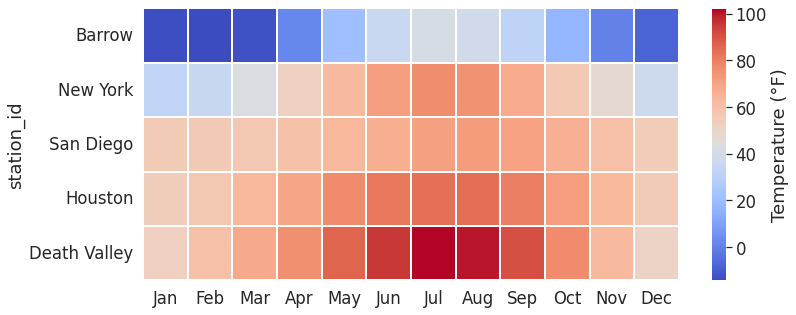

In [22]:
# Plot the heatmap, using the Seaborn library

plt.figure(figsize=(12,5))
sns.heatmap(
    heatmap.T, 
    linewidths=1, 
    cbar_kws={'label': 'Temperature (°F)'}, 
    cmap='coolwarm'
)
pass

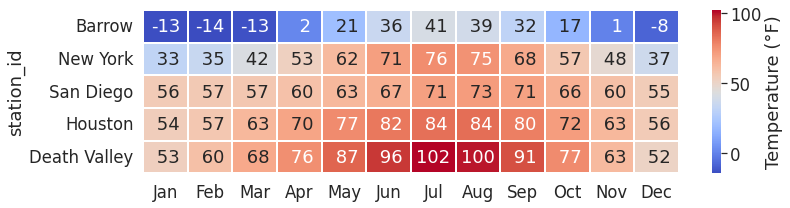

In [23]:
# Same plot, but we now add the temperature values in the boxes
plt.figure(figsize=(12,3))
sns.heatmap(
    heatmap.T, 
    annot=True, # Put the data value in the box
    fmt="3.0f", # formatting the value to have 3 digits with 0 decimals
    linewidths=1, 
    cbar_kws={'label': 'Temperature (°F)'}, 
    cmap='coolwarm'
)

pass

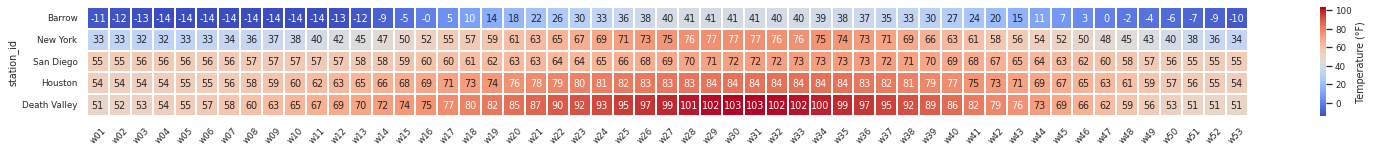

In [24]:
# We now change the granularity to weekly and re-plot

plt.figure(figsize=(26,2))
sns.set(font_scale = 0.8)

# Resampling our dataset to weekly instead of monthly
heatmap = pivot.resample("1W").mean()
# Changing the dates to be "w01", "w02", "w03", etc.
heatmap.index = [f'w{i:02.0f}' for i in range(1,54)]
# Reordering the pivot columns
heatmap = heatmap[locations]

# Same plot as before, but now we add a bit of control for the 
# tick labels (adding 45 degree rotation for the x-axis labels)
g = sns.heatmap(heatmap.T, annot=True, fmt="2.0f", linewidths=1, cbar_kws={'label': 'Temperature (°F)'}, cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(),rotation=0) 
g.set_xticklabels(g.get_xticklabels(),rotation=45) 
pass

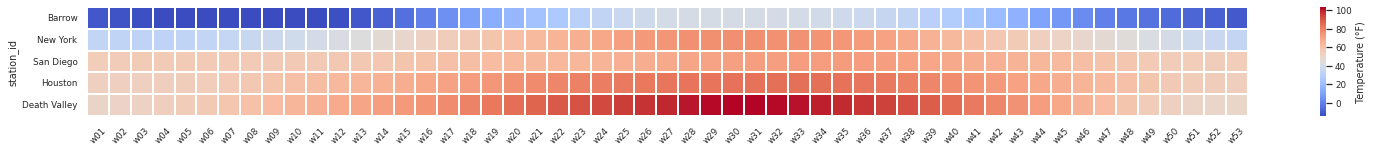

In [25]:
# Removing the annotations for the weekly
plt.figure(figsize=(26,2))
g = sns.heatmap(heatmap.T, linewidths=1, cbar_kws={'label': 'Temperature (°F)'}, cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(),rotation=0) 
g.set_xticklabels(g.get_xticklabels(),rotation=45) 
pass

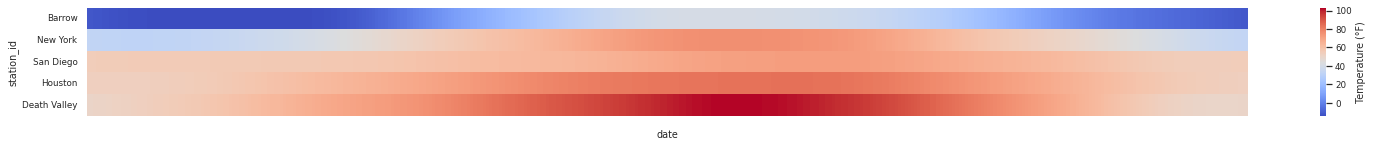

In [26]:
# Reploting daily values. We remove the white lines by removing the 
# option ("linewidths=1")
plt.figure(figsize=(26,2))
heatmap = pivot
heatmap = heatmap[locations]
g = sns.heatmap(heatmap.T, cbar_kws={'label': 'Temperature (°F)'}, cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(),rotation=0)
g.set(xticklabels=[])
pass

## Plotting temperatures of one location against temperatures in another

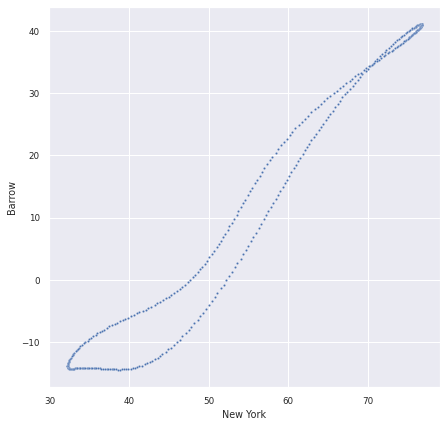

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("whitegrid")

sns.scatterplot(data=pivot, x="New York", y="Barrow", s=5)

### Plotting one location against another, using color to mark the month

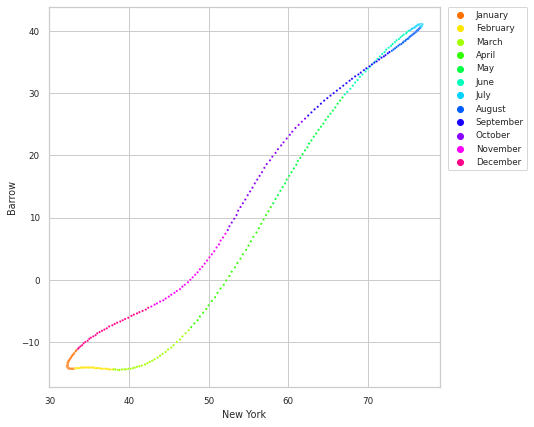

In [28]:
fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("whitegrid")
d = pivot.reset_index()
d['month'] = d['date'].dt.month_name()
sns.scatterplot(data=d, x="New York", y="Barrow", s=5, hue='month', palette="hsv")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## For Further Visualizations: Overall statistics per location

In [29]:
stats = df.pivot_table(
    
    index="station_id", 
    values="temperature", 
    aggfunc=["std",'mean','max','min']
)

stats.columns = ['std_temp', 'avg_temp','max_temp', 'min_temp']
stats = stats.reset_index()

excluded_states = []
# excluded_states = ['HI','CA','FL','WA','OR','AK','TX']
s = stations[~stations["state"].isin(excluded_states)]
stats = pd.merge(stats, s).sort_values('max_temp')
stats

,station_id,std_temp,avg_temp,max_temp,min_temp,lat,lon,elevation,state,name
5980,USW00027502,21.105302,11.778415,41.1,-14.5,71.2833,-156.7814,9.4,AK,BARROW POST ROGERS AP
5188,USC00502126,24.443244,11.347463,45.6,-17.3,70.4322,-150.4094,1.5,AK,COLVILLE VILLAGE
5979,USW00027406,24.709580,10.966866,46.2,-18.0,70.1917,-148.4772,18.6,AK,DEADHORSE AP
5981,USW00027503,23.140785,16.112500,46.3,-15.2,70.6392,-159.9950,9.1,AK,WAINWRIGHT AP
5252,USC00507780,23.936466,12.000546,46.9,-18.3,70.2500,-148.3333,22.9,AK,PRUDHOE BAY
...,...,...,...,...,...,...,...,...,...,...
94,USC00021050,15.065697,74.660383,96.7,53.4,35.1411,-114.5686,161.8,AZ,BULLHEAD CITY
138,USC00024759,15.700194,74.958470,96.9,52.5,34.4500,-114.3667,146.9,AZ,LAKE HAVASU
5808,USW00023179,15.469574,74.173497,97.0,52.1,34.7675,-114.6189,271.3,CA,NEEDLES AP
139,USC00024761,15.701110,74.574590,97.6,51.8,34.5031,-114.3603,136.9,AZ,LAKE HAVASU CITY


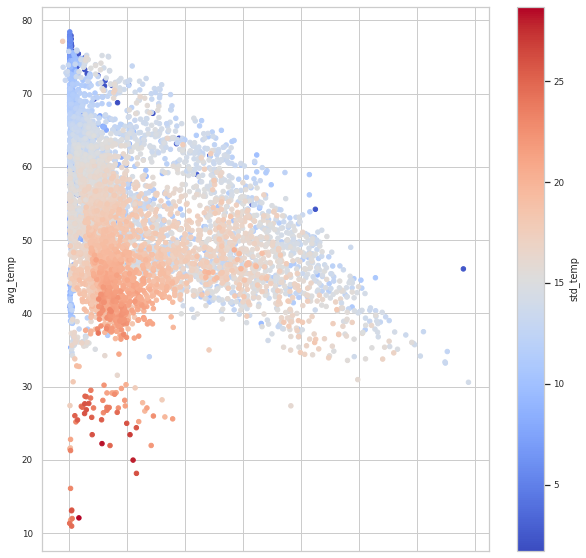

In [30]:
stats.plot(
    kind='scatter',
    x='elevation',
    y='avg_temp',
    c='std_temp',
    cmap = 'coolwarm',
    figsize=(10,10)
)

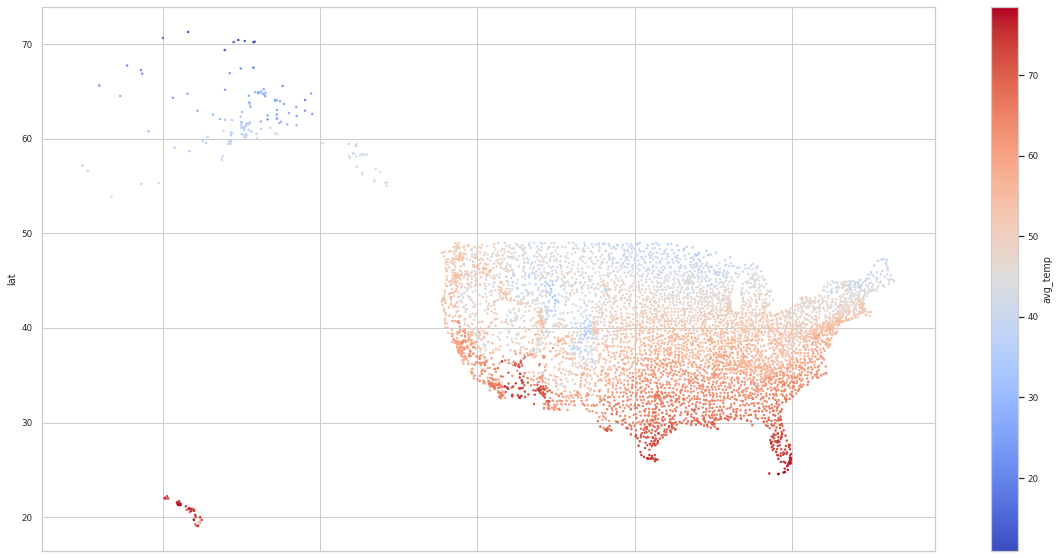

In [33]:
stats.plot(
    kind='scatter',
    x='lon',
    y='lat',
    c='avg_temp',
    cmap = 'coolwarm',
    figsize=(20,10),
    s = 2
)